### Импорт библиотек и датасетов

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression  
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from metrics import get_smoothed_mean_log_accuracy_ratio

In [ ]:
X = pd.read_csv('resources/features.tsv',sep='\t')
Y = pd.read_csv('resources/validate_answers.tsv',sep='\t')

### Разделение данных и масштабирование

In [4]:
X = X.drop(['publishers','user_ids'], axis=1)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

scaler = StandardScaler()
numerical_features = X_train.select_dtypes(include=np.number).columns
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])


### Модель случайного леса и регрессии

In [6]:
models = {
    'at_least_one': {
        'lr': LinearRegression(),
        'rf': RandomForestRegressor(n_estimators=100, random_state=42)
                },
    'at_least_two': {
        'lr': LinearRegression(),
        'rf': RandomForestRegressor(n_estimators=100, random_state=42)
    },
    'at_least_three': {
        'lr': LinearRegression(),
        'rf': RandomForestRegressor(n_estimators=100, random_state=42)
    }
}

In [7]:
predictions = {}  # Изменили название на predictions, т.к. это регрессия
predictions_train = {}

for target in ['at_least_one', 'at_least_two', 'at_least_three']:
    predictions_train[target] = {}
    predictions[target] = {}
    for model_name, model in models[target].items():
        model.fit(X_train, y_train[target])
        predictions_train[target][model_name] = model.predict(X_train)
        predictions[target][model_name] = model.predict(X_test)
        print(f'{model_name} model for {target} is ready!')

lr model for at_least_one is ready!
rf model for at_least_one is ready!
lr model for at_least_two is ready!
rf model for at_least_two is ready!
lr model for at_least_three is ready!
rf model for at_least_three is ready!


In [8]:
weights = {  # Пример весов (нужно подобрать оптимальные значения)
    'lr': 0.5,
    'rf': 0.5
}

In [9]:
ensemble_predictions_weighted = {}

for target in ['at_least_one', 'at_least_two', 'at_least_three']:
    ensemble_predictions_weighted[target] = (
        weights['lr'] * predictions[target]['lr'] +
        weights['rf'] * predictions[target]['rf']
    )

    # Оцениваем качество ансамбля (используем метрики регрессии)
    ensemble_mse_weighted = mean_squared_error(y_test[target], ensemble_predictions_weighted[target])
    ensemble_r2_weighted = r2_score(y_test[target], ensemble_predictions_weighted[target])

    print(f"Ensemble - {target}:")
    print(f"MSE: {ensemble_mse_weighted}")
    print(f"R-squared: {ensemble_r2_weighted}")
    print()

ensemble_predictions_weighted_table = pd.DataFrame(ensemble_predictions_weighted).clip(lower=0) 

print(f'Task metric for Ensemble: { get_smoothed_mean_log_accuracy_ratio(y_test.reset_index(drop=True),ensemble_predictions_weighted_table)}')


Ensemble - at_least_one:
MSE: 0.0032850330923900623
R-squared: 0.8259344789912371

Ensemble - at_least_two:
MSE: 0.002801281137873817
R-squared: 0.7575437483571948

Ensemble - at_least_three:
MSE: 0.001967682900771631
R-squared: 0.7475911745620545

Task metric for Ensemble: 78.62


In [10]:
ensemble_predictions_stacked = {}
ensemble_predictions_stacked_train = {}

for target in ['at_least_one', 'at_least_two', 'at_least_three']:
    meta_features_train = np.column_stack((
        predictions_train[target]['lr'],
        predictions_train[target]['rf']
        ))
    
    meta_features = np.column_stack((
        predictions[target]['lr'],
        predictions[target]['rf']
        ))

    meta_model = RandomForestRegressor(n_estimators=100, random_state=42)  # Мета-модель
    meta_model.fit(meta_features_train, y_train[target])

    ensemble_predictions_stacked_train[target] = meta_model.predict(meta_features_train)
    ensemble_predictions_stacked[target] = meta_model.predict(meta_features)

    ensemble_mse_stacked = mean_squared_error(y_test[target], ensemble_predictions_stacked[target])
    ensemble_r2_stacked = r2_score(y_test[target], ensemble_predictions_stacked[target])

    print(f"Ensemble (Stacking) - {target}:")
    print(f"MSE: {ensemble_mse_stacked}")
    print(f"R-squared: {ensemble_r2_stacked}")
    print()

ensemble_predictions_stacked_table_train = pd.DataFrame(ensemble_predictions_stacked_train).clip(lower=0) 
ensemble_predictions_stacked_table = pd.DataFrame(ensemble_predictions_stacked).clip(lower=0) 

print(f'Task metric for Ensemble on train: { get_smoothed_mean_log_accuracy_ratio(y_train.reset_index(drop=True),ensemble_predictions_stacked_table_train)}')
print(f'Task metric for Ensemble on test: { get_smoothed_mean_log_accuracy_ratio(y_test.reset_index(drop=True),ensemble_predictions_stacked_table)}')

Ensemble (Stacking) - at_least_one:
MSE: 0.0035886690741039604
R-squared: 0.8098455831209117

Ensemble (Stacking) - at_least_two:
MSE: 0.0038202865192772336
R-squared: 0.6693468794893874

Ensemble (Stacking) - at_least_three:
MSE: 0.0021083317877227713
R-squared: 0.7295491311308848

Task metric for Ensemble on train: 5.41
Task metric for Ensemble on test: 38.93


### Визуализация результатов

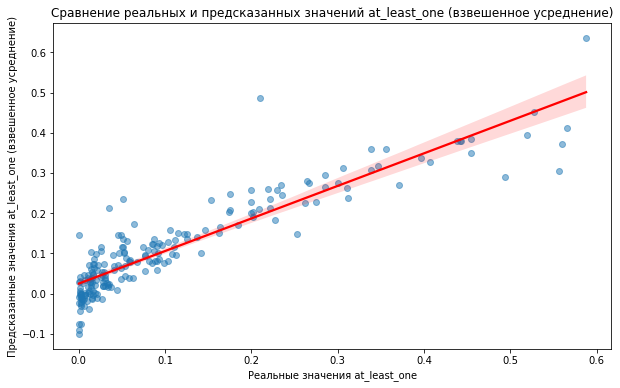

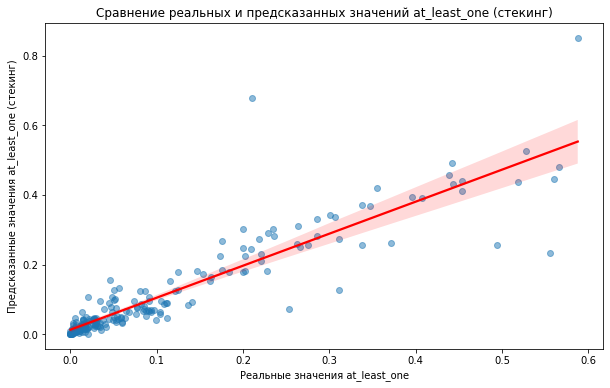

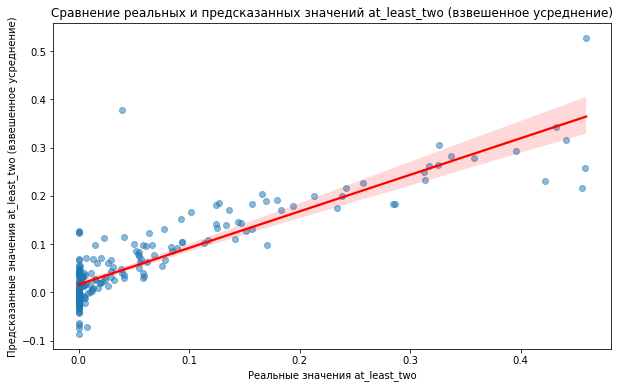

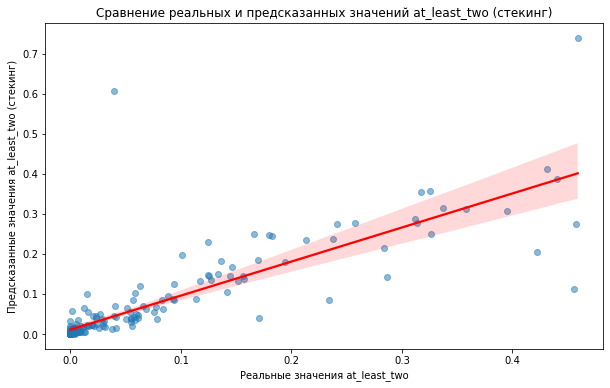

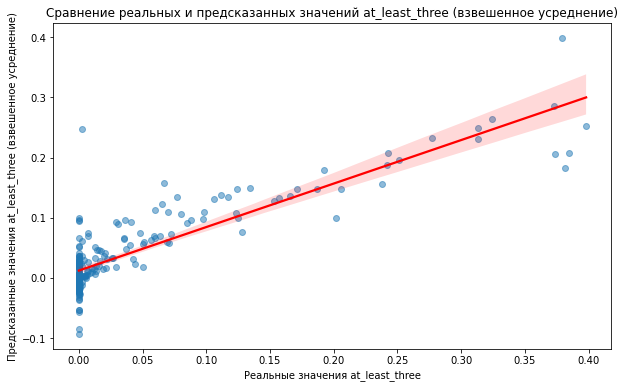

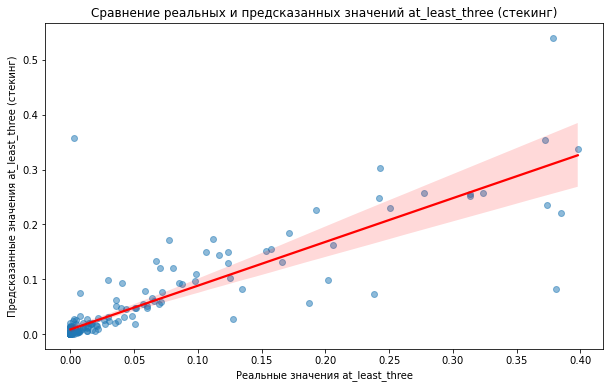

In [11]:
for target in ['at_least_one', 'at_least_two', 'at_least_three']:
    plt.figure(figsize=(10, 6))
    sns.regplot(x=y_test[target], y=ensemble_predictions_weighted[target], scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
    plt.xlabel(f'Реальные значения {target}')
    plt.ylabel(f'Предсказанные значения {target} (взвешенное усреднение)')
    plt.title(f'Сравнение реальных и предсказанных значений {target} (взвешенное усреднение)')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.regplot(x=y_test[target], y=ensemble_predictions_stacked[target], scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
    plt.xlabel(f'Реальные значения {target}')
    plt.ylabel(f'Предсказанные значения {target} (стекинг)')
    plt.title(f'Сравнение реальных и предсказанных значений {target} (стекинг)')
plt.show()

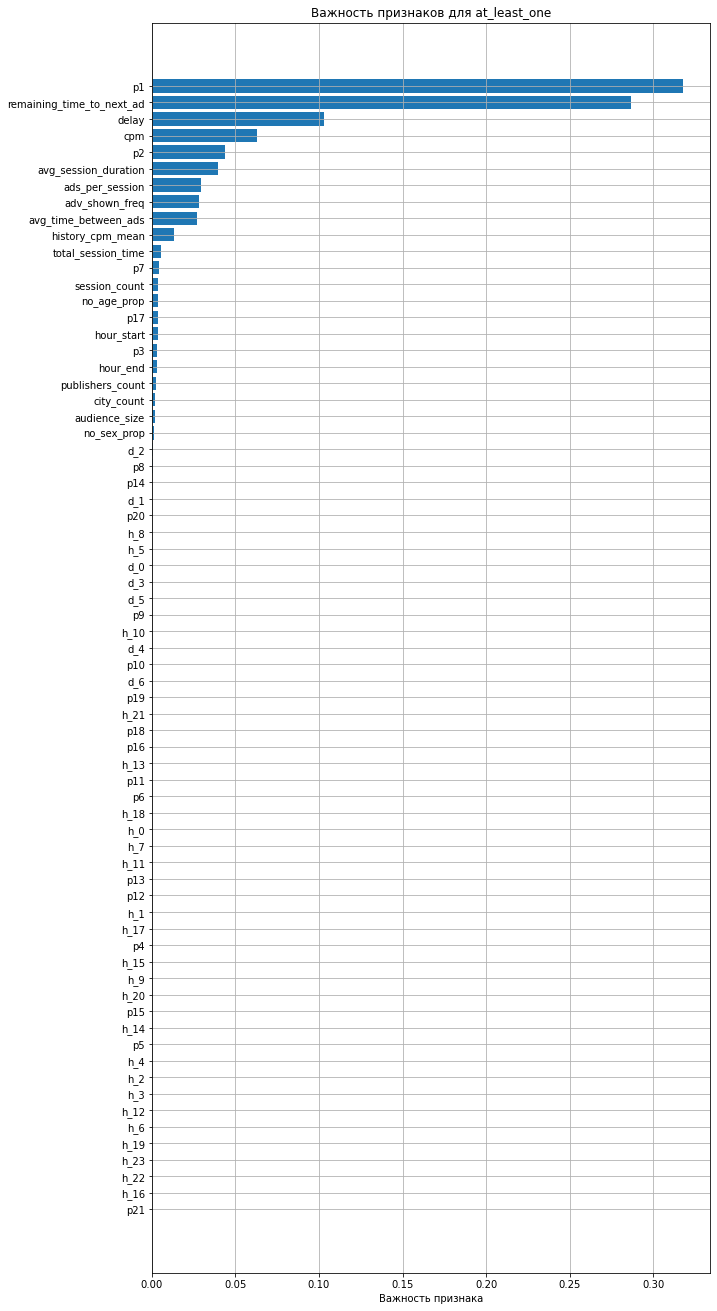

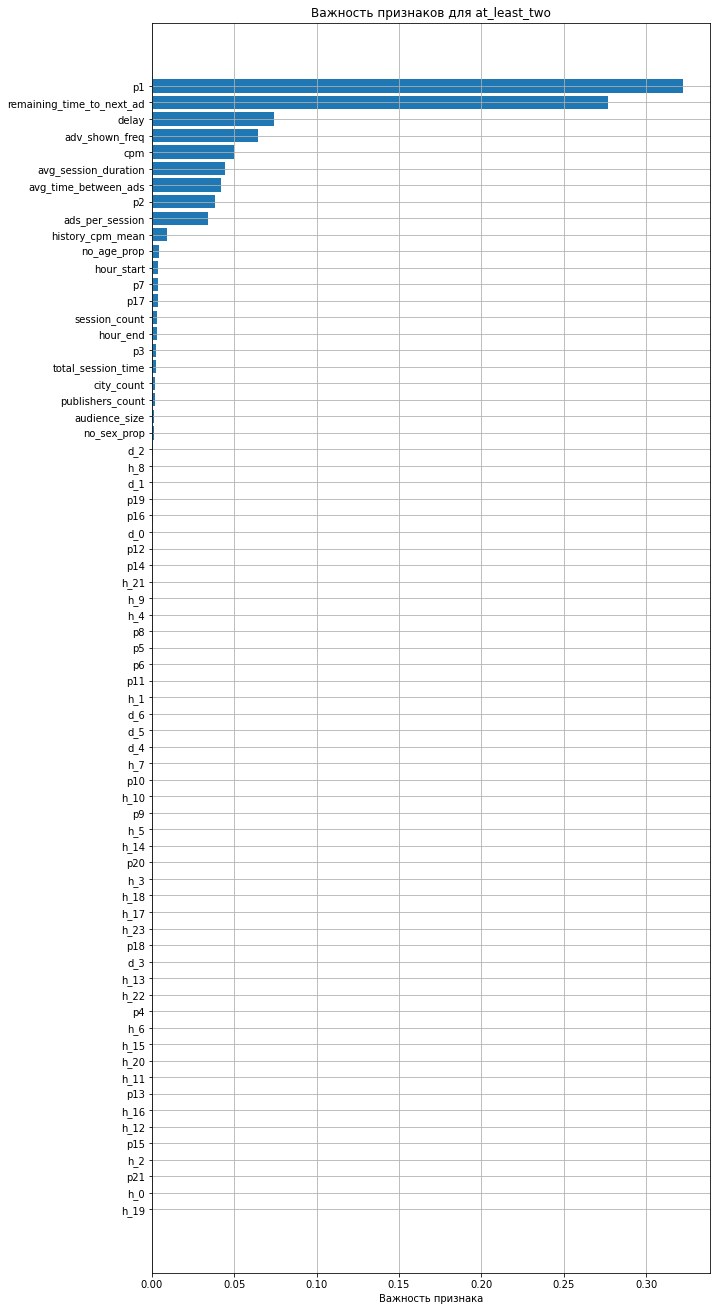

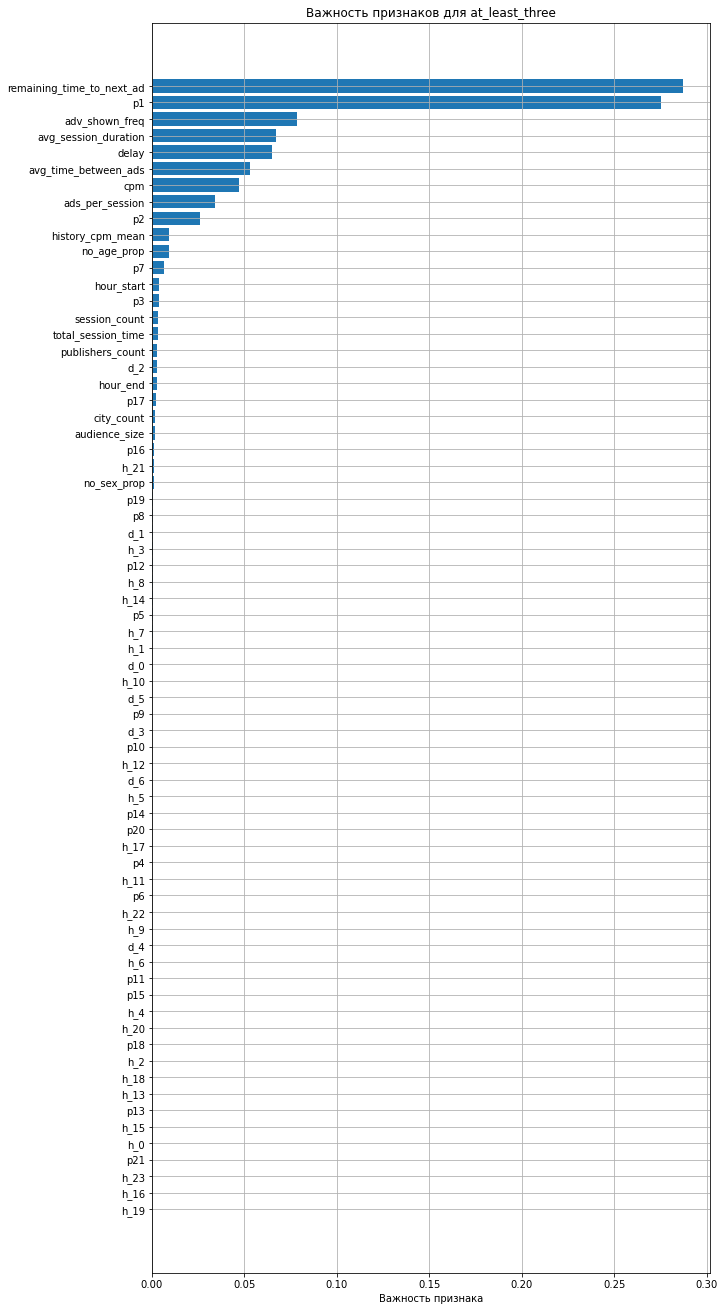

In [12]:
def plot_feature_importance(model, target_name):
    try:
        feature_importance = model.feature_importances_
        sorted_idx = feature_importance.argsort()
        plt.figure(figsize=(10, len(X.columns) // 3))
        plt.barh(X.columns[sorted_idx], feature_importance[sorted_idx])
        plt.xlabel('Важность признака')
        plt.title(f'Важность признаков для {target_name}')
        plt.grid()
        plt.show()
    except AttributeError:  # Handle models without feature_importances_
        print(f"Модель {model.__class__.__name__} не имеет атрибута feature_importances_")

for target in ['at_least_one', 'at_least_two', 'at_least_three']:
    for model_name in ['rf']:
        model = models[target][model_name]
        plot_feature_importance(model, target)

### Сохранение результата

In [13]:
ensemble_predictions_weighted_table.to_csv('results/test_weighted_result.tsv', sep='\t', index=False)
ensemble_predictions_stacked_table.to_csv('results/test_stacked_result.tsv', sep='\t', index=False)
y_test.to_csv('results/test_answers.tsv', sep='\t', index=False)